### 1. Preliminaries

In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy 
import networkx as nx
import pickle

#REF: Adapted from: https://github.com/alpha2phi/jupyter-notebooks/blob/main/nbs/10_network_and_graph.ipynb 
# MIT License

# Copyright (c) 2020 alpha2phi

In [2]:
co_occurrence_dict = pickle.load(open('../Data/co_occurrence_dict_v20240223.pickle', 'rb'))

In [3]:
# dictionary of countries and their neighboring countries (where links should be in the plot)

df_p90 = pd.read_csv('../Data/residual/p90_by_country.csv') # for size of nodes, based on p90 of residual load

get_coordinates = False # set to true if coordinates need to be fetched from geopy

europe_neighbors = {
    'AUT': ['DEU', 'CZE', 'SVK', 'HUN', 'SVN', 'ITA', 'CHE'],
    'BEL': ['NLD', 'DEU', 'FRA', 'GBR'],
    'CHE': ['DEU', 'AUT', 'FRA', 'ITA'],
    'CZE': ['DEU', 'AUT', 'SVK', 'POL'],
    'DEU': ['DNK', 'NLD', 'BEL', 'FRA', 'CHE', 'AUT', 'CZE', 'POL', 'GBR', 'CHE', 'NOR', 'SWE'],
    'DNK': ['DEU', 'SWE', 'NOR', 'GBR'],
    'ESP': ['FRA', 'PRT'],
    'EST': ['FIN', 'LVA'],
    'FIN': ['SWE', 'EST', 'NOR'],
    'FRA': ['BEL', 'DEU', 'CHE', 'ITA', 'ESP', 'GBR', 'IRL'],
    'GBR': ['IRL', 'FRA', 'BEL', 'NLD', 'DEU', 'DNK', 'NOR'],
    'HRV': ['SVN', 'HUN', 'ITA'],
    'HUN': ['AUT', 'SVK', 'HRV', 'SVN'],
    'IRL': ['GBR', 'FRA'],
    'ITA': ['FRA', 'CHE', 'AUT', 'SVN', 'HRV'],
    'LTU': ['LVA', 'POL', 'SWE'],
    'LVA': ['EST', 'LTU', 'SWE'],
    'NLD': ['BEL', 'DEU', 'GBR', 'DNK', 'NOR'],
    'NOR': ['SWE', 'DNK', 'GBR', 'NLD', 'DEU', 'FIN'],
    'POL': ['DEU', 'CZE', 'SVK', 'LTU', 'SWE'],
    'PRT': ['ESP'],
    'SVK': ['POL', 'CZE', 'AUT', 'HUN'],
    'SVN': ['AUT', 'ITA', 'HUN', 'HRV'],
    'SWE': ['NOR', 'FIN', 'DNK', 'DEU', 'POL', 'LTU', 'LVA']
}

# List of countries
countries_ISO3 = ['AUT', 'BEL', 'CHE', 'CZE', 'DEU', 'DNK',
             'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'HRV', 'HUN', 'IRL',
             'ITA', 'LTU', 'LVA', 'NLD', 'NOR', 'POL', 'PRT',
             'SVK', 'SVN', 'SWE']

countries_ISO2 = ['AT', 'BE','CH', 'CZ', 'DE', 'DK',
 'ES', 'EE', 'FI', 'FR', 'GB', 'HR', 'HU', 'IE',
 'IT', 'LT', 'LV', 'NL', 'NO', 'PL', 'PT',
'SK', 'SI', 'SE']


In [4]:
if get_coordinates:
    # Initialize geolocator with OpenStreetMap's Nominatim and include the country name
    geolocator = Nominatim(user_agent="country_locator_v4")

    # Function to get central latitude and longitude for a country
    def get_central_coordinates(country_code):
        location = geolocator.geocode(country_code)
        return (location.latitude, location.longitude) if location else (None, None)

    # Create a DataFrame
    columns = ['Country', 'Latitude', 'Longitude']
    data = []

    for i, country_code in enumerate(countries_ISO2):
        latitude, longitude = get_central_coordinates(country_code)
        data.append([countries_ISO3[i], latitude, longitude])

    df_coordinates = pd.DataFrame(data, columns=columns)
    df_coordinates.to_csv('../Data/country_coordinates_v20240123.csv', index=False)
else:
    df_coordinates = pd.read_csv('../Data/country_coordinates_v20240123.csv')

### 2. Define functions

In [5]:
def merge_dataframes(df_co, df_coordinates):
    df_co = df_co[df_co['prob'] != 1]

    # Create a copy of the original dataframe
    df_full = df_co.copy()

    # Merge on country_1
    df_full = df_full.merge(df_coordinates, left_on='country_1', right_on='Country', how='left')

    # Rename the new columns
    df_full = df_full.rename(columns={'Latitude': 'Latitude_1', 'Longitude': 'Longitude_1'})

    # Drop the extra 'country' column
    df_full = df_full.drop(columns='Country')

    # Merge on country_2
    df_full = df_full.merge(df_coordinates, left_on='country_2', right_on='Country', how='left')

    # Rename the new columns
    df_full = df_full.rename(columns={'Latitude': 'Latitude_2', 'Longitude': 'Longitude_2'})

    # Drop the extra 'country' column
    df_full = df_full.drop(columns='Country')

    # Filter the dataframe
    df_neighbors = df_full[df_full.apply(lambda row: row['country_2'] in europe_neighbors.get(row['country_1'], []), axis=1)]

    # Create a new column with a sorted tuple of Country_1 and Country_2
    df_neighbors['Country_Pair'] = df_neighbors.apply(lambda row: tuple(sorted([row['country_1'], row['country_2']])), axis=1)

    # Drop duplicates based on the new column
    df_neighbors = df_neighbors.drop_duplicates(subset='Country_Pair')

    # Drop the new column as it's no longer needed
    df = df_neighbors.drop(columns='Country_Pair')

    edges = df[['country_1', 'country_2']].values
    g = nx.from_edgelist(edges)
    sg = next(g.subgraph(c) for c in nx.connected_components(g))
    return df, sg

In [6]:
def plot_network_old(df, sg, regime_title): 
    countries = {}

    for index, row in df.iterrows():
        if not row['country_1'] in countries:
            countries[row['country_1']] = (row['Longitude_1'], row['Latitude_1'])
        if not row['country_2'] in countries:
            countries[row['country_2']] = (row['Longitude_2'], row['Latitude_2'])

    probabilities = []
    for edge in sg.edges():
        country_1, country_2 = edge
        # Try querying in the original order
        matching_rows = df.query(f'country_1 == "{country_1}" and country_2 == "{country_2}"')
        
        # If no matching rows, try querying in the reversed order
        if matching_rows.empty:
            matching_rows = df.query(f'country_1 == "{country_2}" and country_2 == "{country_1}"')
        if not matching_rows.empty:
            prob = matching_rows.iloc[0]['prob']
            probabilities.append(prob)
        else:
            print('Problem')
    #TODO: Right now it's not doing anything with the asymmetry, and just picking one randomly.
    probabilities = np.asarray(probabilities)

    scalarMap = cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(vmin=0, vmax=1))
    scalarMap.set_array(probabilities)

    edge_colors = scalarMap.to_rgba(probabilities)

    #TODO: Add white node inside black node, to show which part of the demand is covered by renewables
    p90_per_country = [df_p90.query('Country_name == @cname')['p90'].values[0] for cname in sg.nodes]
    sizes = 900 * (p90_per_country / np.max(p90_per_country))

    sizes_dict = {country: size for country, size in zip(sg.nodes(), sizes)}
    edge_widths = []

    for country_1, country_2 in sg.edges():
        edge_widths.append((sizes_dict[country_1] * sizes_dict[country_2])**(1/4))

    max_edge_width = max(edge_widths)
    edge_widths = [12 * width / max_edge_width for width in edge_widths]

    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 7),
        subplot_kw=dict(projection=crs))
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cartopy.feature.LAND, facecolor='lightgrey')  # Set the land color to lightgrey
    ax.set_extent([-12, 30, 35, 72])

    nx.draw_networkx(sg, ax=ax,
                    font_size=16,
                    width=edge_widths,
                    node_size=sizes,
                    node_color='k',
                    pos=countries,
                    edge_color=edge_colors.squeeze(),
                    with_labels = False)

    cbar = plt.colorbar(scalarMap, ax=ax, shrink=0.75)
    plt.title(f'Co-occurrence probability between neighboring countries, regime = {regime_title}', fontsize=12)
    plt.tight_layout()


In [7]:
def plot_network(df, sg, regime_title): 
    countries = {}

    for index, row in df.iterrows():
        if not row['country_1'] in countries:
            countries[row['country_1']] = (row['Longitude_1'], row['Latitude_1'])
        if not row['country_2'] in countries:
            countries[row['country_2']] = (row['Longitude_2'], row['Latitude_2'])

    probabilities = []
    for edge in sg.edges():
        country_1, country_2 = edge
        # Try querying in the original order
        matching_rows = df.query(f'country_1 == "{country_1}" and country_2 == "{country_2}"')
        
        # If no matching rows, try querying in the reversed order
        if matching_rows.empty:
            matching_rows = df.query(f'country_1 == "{country_2}" and country_2 == "{country_1}"')
        if not matching_rows.empty:
            prob = matching_rows.iloc[0]['prob']
            probabilities.append(prob)
        else:
            print('Problem')

    probabilities = np.asarray(probabilities)

    scalarMap = cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(vmin=0, vmax=1))
    scalarMap.set_array(probabilities)

    edge_colors = scalarMap.to_rgba(probabilities)

    #TODO: Add white node inside black node, to show which part of the demand is covered by renewables
    p90_per_country = [df_p90.query('Country_name == @cname')['p90'].values[0] for cname in sg.nodes]
    sizes = 900 * (p90_per_country / np.max(p90_per_country))

    sizes_dict = {country: size for country, size in zip(sg.nodes(), sizes)}
    edge_widths = []

    for country_1, country_2 in sg.edges():
        edge_widths.append((sizes_dict[country_1] + sizes_dict[country_2])**(1/2))

    max_edge_width = max(edge_widths)
    edge_widths = [12 * width / max_edge_width for width in edge_widths]

    # crs = ccrs.PlateCarree()
    lonmin, lonmax, latmin, latmax = -12, 25, 35, 72

    #projection = ccrs.LambertConformal(central_longitude=(lonmax-lonmin)/2, central_latitude=(latmax-latmin)/2)
    projection = ccrs.LambertConformal(central_longitude=0, central_latitude=45)
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 7),
        subplot_kw=dict(projection=projection))
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    ax.add_feature(cartopy.feature.LAND, facecolor='lightgrey')  # Set the land color to lightgrey
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())

    lambert_pos = {country: projection.transform_point(lon, lat, ccrs.PlateCarree()) for country, (lon, lat) in countries.items()}

    nx.draw_networkx(sg, ax=ax,
                    font_size=16,
                    width=edge_widths,
                    node_size=sizes,
                    node_color='k',
                    pos=lambert_pos,
                    edge_color=edge_colors.squeeze(),
                    with_labels = False)

    cbar = plt.colorbar(scalarMap, ax=ax, shrink=0.75)
    plt.title(f'Co-occurrence probability between neighboring countries, regime = {regime_title}', fontsize=12)

/tmp/ipykernel_669818/2509280405.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbors['Country_Pair'] = df_neighbors.apply(lambda row: tuple(sorted([row['country_1'], row['country_2']])), axis=1)


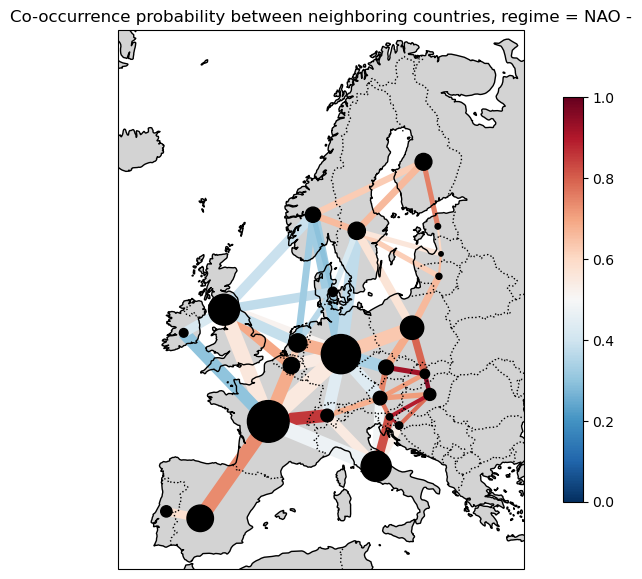

In [8]:
df_co = co_occurrence_dict['NAO -']['prob_df']
df, sg = merge_dataframes(df_co, df_coordinates)
plot_network(df, sg, 'NAO -')

/tmp/ipykernel_669818/2509280405.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbors['Country_Pair'] = df_neighbors.apply(lambda row: tuple(sorted([row['country_1'], row['country_2']])), axis=1)


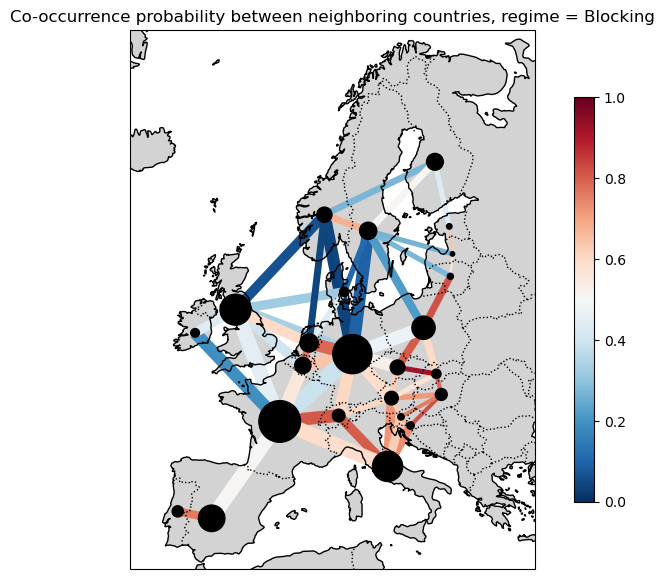

In [9]:
df_co = co_occurrence_dict['Blocking']['prob_df']
df, sg = merge_dataframes(df_co, df_coordinates)
plot_network(df, sg, 'Blocking')

/tmp/ipykernel_669818/2509280405.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbors['Country_Pair'] = df_neighbors.apply(lambda row: tuple(sorted([row['country_1'], row['country_2']])), axis=1)


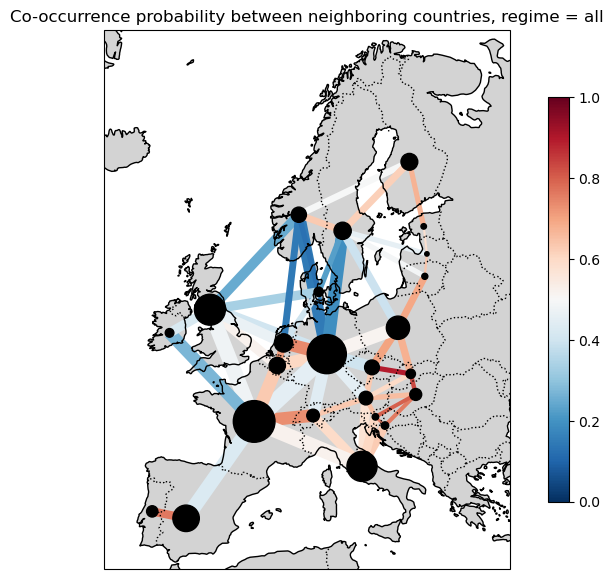

In [10]:
df_co = co_occurrence_dict['All']['prob_df']
df, sg = merge_dataframes(df_co, df_coordinates)
plot_network(df, sg, 'all')